In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import math


In [4]:
DEVICE = "cude" if torch.cuda.is_available() else "cpu"

print(f'Using device {DEVICE}')

Using device cpu


In [7]:
img_size = 32
batch_size = 128

transforms = v2.Compose([
    v2.Resize((img_size, img_size)), # resize to 32*32
    v2.ToTensor(),
    v2.Lambda(lambda t:(t*2)-1) # change all the grid values into the range [-1.0, 1.0]
    ])

dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transforms)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)




100%|██████████| 170M/170M [03:29<00:00, 816kB/s]    


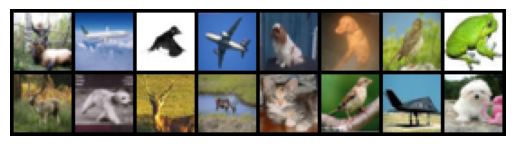

In [9]:
def show_img(images, title=""):
    images = (images+1) /2
    images = images.clamp(0, 1)

    grid_img = torchvision.utils.make_grid(images, nrow = 8)
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()


image_batch , _= next(iter(dataloader))
show_img(image_batch[:16])